# 决策树回归 Decision Tree Regression
## 算法实现 implementation of algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 数据集 Dataset

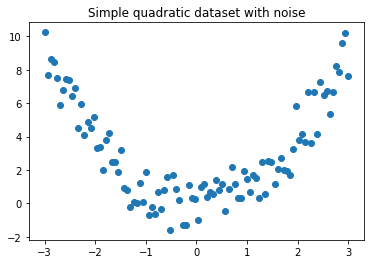

In [2]:
X = np.linspace(-3, 3, 100)
y = X ** 2 + np.random.randn(100)
X = X[:,np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X, y)
plt.title("Simple quadratic dataset with noise")
plt.show()

In [3]:
class DecisionTreeRegression():
    def __init__(self):
        '''
        树数据结构：
                根
              (元素)
        (feature,threshold)
                /\
               /  \
              /    \
           左子树 右子树
           (元素) (元素)
            /  \   /  \
           叶  叶 ...
         (类别)
        '''
        self.tree = None
        
    def split(self, X, y, feature, value):
        '''
        分割子树，返回左右子树
        '''
        index_l = (X[:,feature] <= value)
        index_r = (X[:,feature] > value)
        return X[index_l], X[index_r], y[index_l], y[index_r]

    def mean_squared_error(self, y):
        '''
        计算MSE
        '''
        y_hat = (1 / len(y)) * np.sum(y)
        mse = (1 / len(y)) * np.sum((y - y_hat) ** 2)
        return mse

    def find_best_split(self, X, y):
        '''
        寻找最佳分割特征以及阈值
        '''
        best_entropy = float('inf')
        best_feature, threshold = -1, -1
        n_samples, n_features = X.shape
        for feature in range(n_features):
            sorted_index = np.argsort(X[:,feature])
            for i in range(1, len(X)):
                if X[sorted_index[i], feature] != X[sorted_index[i-1], feature]:
                    value = (X[sorted_index[i], feature] + X[sorted_index[i-1], feature]) / 2
                    X_l, X_r, y_l, y_r = self.split(X, y, feature, value)
                    e = len(y_l)/len(y) * self.mean_squared_error(y_l) + len(y_r)/len(y) * self.mean_squared_error(y_r)
                    if e < best_entropy:
                        best_entropy, best_feature, threshold = e, feature, value
        return {'feature':best_feature, 'threshold':threshold}
    
    def create_leaf(self, y):
        '''
        构建叶子节点
        '''
        return np.mean(y)
    
    def build_tree(self, X_train, y_train, node, depth, max_depth, min_samples):
        '''
        构建当前节点的树
        '''
        left_samples, right_samples, y_left_samples, y_right_samples = self.split(X_train, y_train, node['feature'], node['threshold'])

        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node["left_child"] = node["right_child"] = self.create_leaf(np.append(y_left_samples, y_right_samples))
            return None

        if depth >= max_depth:
            node["left_child"] = self.create_leaf(y_left_samples)
            node["right_child"] = self.create_leaf(y_right_samples)
            return None

        if len(right_samples) < min_samples:
            node["right_child"] = self.create_leaf(y_right_samples)
        else:
            node["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(right_samples, y_right_samples, node["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node["left_child"] = self.create_leaf(y_left_samples)
        else:
            node["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(left_samples, y_left_samples, node["left_child"], depth+1, max_depth, min_samples)

        return node
    
    def fit(self, X_train, y_train, max_depth, min_samples):
        root = self.find_best_split(X, y)
        self.tree = self.build_tree(X_train, y_train, root, 1, max_depth, min_samples)
    
    def predict(self, X_test, node=None):
        if node is None:
            node = self.tree
        feature = node['feature']
        threshold = node['threshold']
        if X_test[feature] < threshold:
            if isinstance(node['left_child'], float):
                return node['left_child']
            else:
                prediction = self.predict(X_test, node['left_child'])
        elif X_test[feature] >= threshold:
            if isinstance(node['right_child'], float):
                return node['right_child']
            else:
                prediction = self.predict(X_test, node['right_child'])

        return prediction

### 测试 Testing

In [4]:
reg = DecisionTreeRegression()
reg.fit(X_train, y_train, max_depth=2, min_samples=1)
y_p_test = np.array([reg.predict(x) for x in X_test])
print(reg.tree)

{'feature': 0, 'threshold': -2.0, 'right_child': {'feature': 0, 'threshold': 1.9696969696969697, 'left_child': 1.1863883968765392, 'right_child': 6.1661050365866155}, 'left_child': {'feature': 0, 'threshold': -2.3636363636363633, 'left_child': 7.580987264480796, 'right_child': 4.849983738523936}}


In [5]:
def score(y, y_p):
    mse = np.sum((y - y_p)**2) / len(y)
    return 1 - mse/np.var(y)
score(y_test,y_p_test)

0.7438641362622342

### 决策边界可视化 Visualize decision boundary

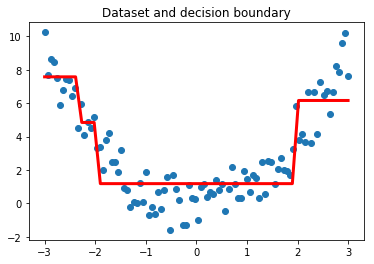

In [6]:
plt.scatter(X, y)
X_v = np.linspace(-3,3,50)
X_v = X_v[:,np.newaxis]
y_v = np.array([reg.predict(x) for x in X_v])
plt.plot(X_v, y_v, linewidth=3, c='r')
plt.title("Dataset and decision boundary")
plt.show()

## scikit-learn

In [7]:
from sklearn.tree import DecisionTreeRegressor

In [8]:
dt_reg = DecisionTreeRegressor(max_depth=2)
dt_reg.fit(X_train, y_train)
dt_reg.score(X_test, y_test)

0.5716757768503619

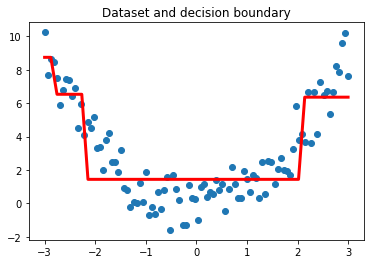

In [9]:
plt.scatter(X, y)
X_v = np.linspace(-3,3,50)
X_v = X_v[:,np.newaxis]
y_v = dt_reg.predict(X_v)
plt.plot(X_v, y_v, linewidth=3, c='r')
plt.title("Dataset and decision boundary")
plt.show()